# Using a "black box" likelihood function

In [1]:
import arviz as az
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

[PyMC3](https://docs.pymc.io/index.html) is a great tool for doing Bayesian inference and parameter estimation. It has a load of [in-built probability distributions](https://docs.pymc.io/api/distributions.html) that you can use to set up priors and likelihood functions for your particular model. You can even create your own [custom distributions](https://docs.pymc.io/prob_dists.html#custom-distributions).

However, this is not necessarily that simple if you have a model function, or probability distribution, that, for example, relies on an external code that you have little/no control over (and may even be, for example, wrapped `C` code rather than Python). This can be problematic went you need to pass parameters set as PyMC3 distributions to these external functions; your external function probably wants you to pass it floating point numbers rather than PyMC3 distributions!

```python
import pymc3 as pm:
from external_module import my_external_func  # your external function!

# set up your model
with pm.Model():
    # your external function takes two parameters, a and b, with Uniform priors
    a = pm.Uniform('a', lower=0., upper=1.)
    b = pm.Uniform('b', lower=0., upper=1.)
    
    m = my_external_func(a, b)  # <--- this is not going to work!
```

Another issue is that if you want to be able to use the [gradient-based step samplers](https://docs.pymc.io/notebooks/getting_started.html#Gradient-based-sampling-methods) like [NUTS](https://docs.pymc.io/api/inference.html#module-pymc3.step_methods.hmc.nuts) and [Hamiltonian Monte Carlo (HMC)](https://docs.pymc.io/api/inference.html#hamiltonian-monte-carlo), then your model/likelihood needs a gradient to be defined. If you have a model that is defined as a set of Theano operators then this is no problem - internally it will be able to do automatic differentiation - but if your model is essentially a "black box" then you won't necessarily know what the gradients are.

Defining a model/likelihood that PyMC3 can use and that calls your "black box" function is possible, but it relies on creating a [custom Theano Op](https://docs.pymc.io/advanced_theano.html#writing-custom-theano-ops). This is, hopefully, a clear description of how to do this, including one way of writing a gradient function that could be generally applicable.

In the examples below, we create a very simple model and log-likelihood function in numpy.

In [3]:
def my_model(theta, x):
    m, c = theta
    return m*x + c

def my_loglike(theta, x, data, sigma):
    model= my_model(theta, x)
    return -(0.5/sigma**2)*np.sum((data - model)**2)

Now, as things are, if we wanted to sample from this log-likelihood function, using certain prior distributions for the model parameters (gradient and y-intercept) using PyMC3, we might try something like this (using a [PyMC3 DensityDist](https://docs.pymc.io/prob_dists.html#custom-distributions)):

```python
import pymc3 as pm

# create/read in our "data" (I'll show this in the real example below)
x = ...
sigma = ...
data = ...

with pm.Model():
    # set priors on model gradient and y-intercept
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # create custom distribution 
    pm.DensityDist('likelihood', my_loglike,
                   observed={'theta': (m, c), 'x': x, 'data': data, 'sigma': sigma})
    
    # sample from the distribution
    trace = pm.sample(1000)
```

But, this will give an error like:

```
ValueError: setting an array element with a sequence.
```

This is because `m` and `c` are Theano tensor-type objects.

So, what we actually need to do is create a [Theano Op](http://deeplearning.net/software/theano/extending/extending_theano.html). This will be a new class that wraps our log-likelihood function (or just our model function, if that is all that is required) into something that can take in Theano tensor objects, but internally can cast them as floating point values that can be passed to our log-likelihood function. We will do this below, initially without defining a [grad() method](http://deeplearning.net/software/theano/extending/op.html#grad) for the Op.

In [4]:
# define a theano Op for our likelihood function
class LogLike(tt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

Now, let's use this Op to repeat the example shown above. To do this let's create some data containing a straight line with additive Gaussian noise (with a mean of zero and a standard deviation of `sigma`). For simplicity we set [uniform](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Uniform) prior distributions on the gradient and y-intercept. As we've not set the `grad()` method of the Op PyMC3 will not be able to use the gradient-based samplers, so will fall back to using the [Slice](https://docs.pymc.io/api/inference.html#module-pymc3.step_methods.slicer) sampler.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [c]
>Slice: [m]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


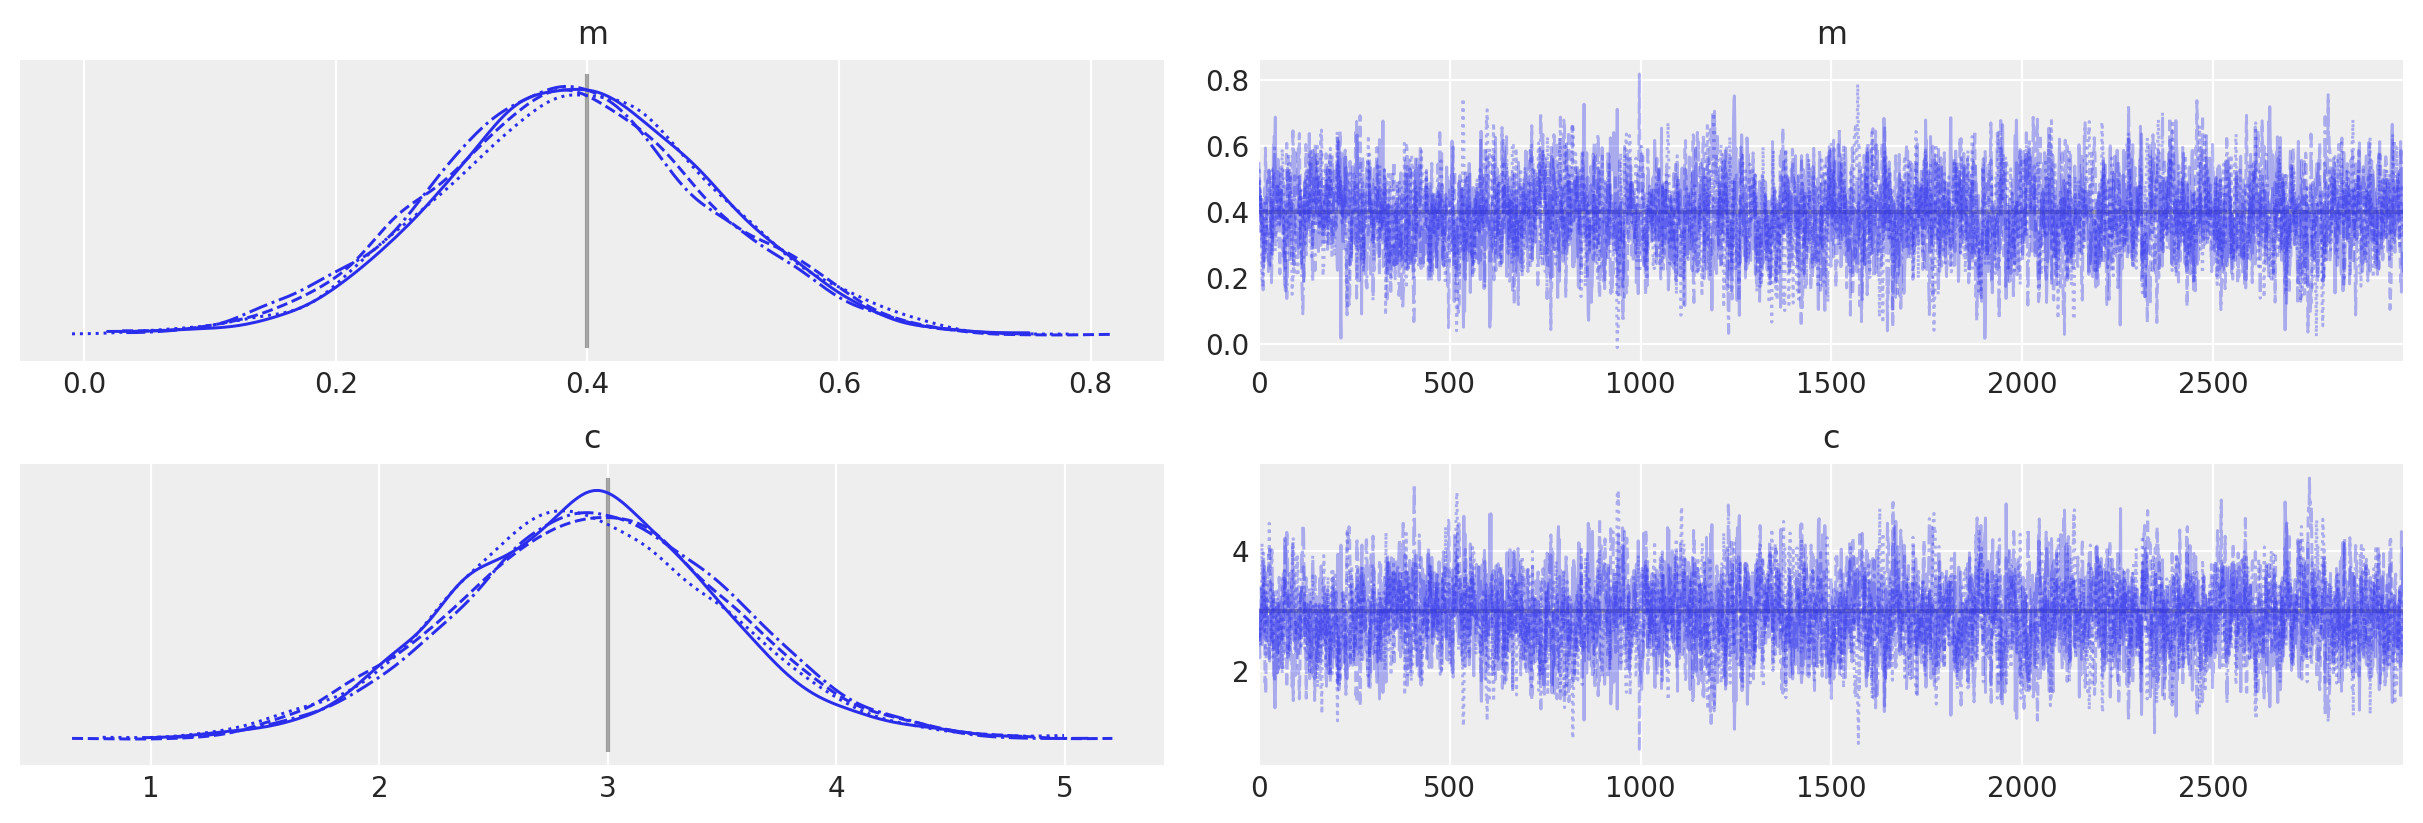

In [5]:
# set up our data
N = 10  # number of data points
sigma = 1.0  # standard deviation of noise
x = np.linspace(0.0, 9.0, N)

mtrue = 0.4  # true gradient
ctrue = 3.0  # true y-intercept

truemodel = my_model([mtrue, ctrue], x)

# make data
np.random.seed(716742)  # set random seed, so the data is reproducible each time
data = sigma * np.random.randn(N) + truemodel

ndraws = 3000  # number of draws from the distribution
nburn = 1000  # number of "burn-in points" (which we'll discard)

# create our Op
logl = LogLike(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", lambda v: logl(v), givens={"v": theta})

    idata_mh = pm.sample(ndraws, tune=nburn, return_inferencedata=True)

# plot the traces
_ = az.plot_trace(idata_mh, lines=[("m", {}, mtrue), ("c", {}, ctrue)])

# put the chains in an array (for later!)
samples_mh = idata_mh.posterior.stack(sample=("chain", "draw")).to_array().values.T

What if we wanted to use NUTS or HMC? If we knew the analytical derivatives of the model/likelihood function then we could add a [grad() method](http://deeplearning.net/software/theano/extending/op.html#grad) to the Op using that analytical form.

But, what if we don't know the analytical form. If our model/likelihood is purely Python and made up of standard maths operators and Numpy functions, then the [autograd](https://github.com/HIPS/autograd) module could potentially be used to find gradients (also, see [here](https://github.com/ActiveState/code/blob/master/recipes/Python/580610_Auto_differentiation/recipe-580610.py) for a nice Python example of automatic differentiation). But, if our model/likelihood truely is a "black box" then we can just use the good-old-fashioned [finite difference](https://en.wikipedia.org/wiki/Finite_difference) to find the gradients - this can be slow, especially if there are a large number of variables, or the model takes a long time to evaluate. Below, a function to find gradients has been defined that uses the finite difference (the central difference) - it uses an iterative method with successively smaller interval sizes to check that the gradient converges. But, you could do something far simpler and just use, for example, the SciPy [approx_fprime](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.approx_fprime.html) function. Here, the gradient function is defined in Cython for speed, but if the function it evaluates to find the gradients is the performance bottle neck then having this as a pure Python function may not make a significant speed difference.

Note that since PyMC3 3.11.0, normalization constants are dropped from the computation, thus, we will do the same to ensure both gradients return exactly the same value (which will be checked below). As `sigma=1` in this case the dropped factor is only a factor 2, but for completeness, the term is shown as a comment. Try to see what happens if you uncomment this term and rerun the whole notebook.

In [6]:
def normal_gradients(theta, x, data, sigma):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    theta: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    x, data, sigma:
        Observed variables as we have been using so far
    

    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.empty(2)
    aux_vect = (data - my_model(theta, x)) # /(2*sigma**2)
    grads[0] = np.sum(aux_vect*x)
    grads[1] = np.sum(aux_vect)
    
    return grads

So, now we can just redefine our Op with a `grad()` method, right?

It's not quite so simple! The `grad()` method itself requires that its inputs are Theano tensor variables, whereas our `gradients` function above, like our `my_loglike` function, wants a list of floating point values. So, we need to define another Op that calculates the gradients. Below, I define a new version of the `LogLike` Op, called `LogLikeWithGrad` this time, that has a `grad()` method. This is followed by anothor Op called `LogLikeGrad` that, when called with a vector of Theano tensor variables, returns another vector of values that are the gradients (i.e., the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)) of our log-likelihood function at those values. Note that the `grad()` method itself does not return the gradients directly, but instead returns the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)-vector product (you can hopefully just copy what I've done and not worry about what this means too much!).

In [7]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.data, self.x, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        return [g[0] * self.logpgrad(theta)]


class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """

    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        (theta,) = inputs

        # calculate gradients
        grads = normal_gradients(theta, self.x, self.data, self.sigma)

        outputs[0][0] = grads

Now, let's re-run PyMC3 with our new "grad"-ed Op. This time it will be able to automatically use NUTS.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, m]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8846922243635593, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


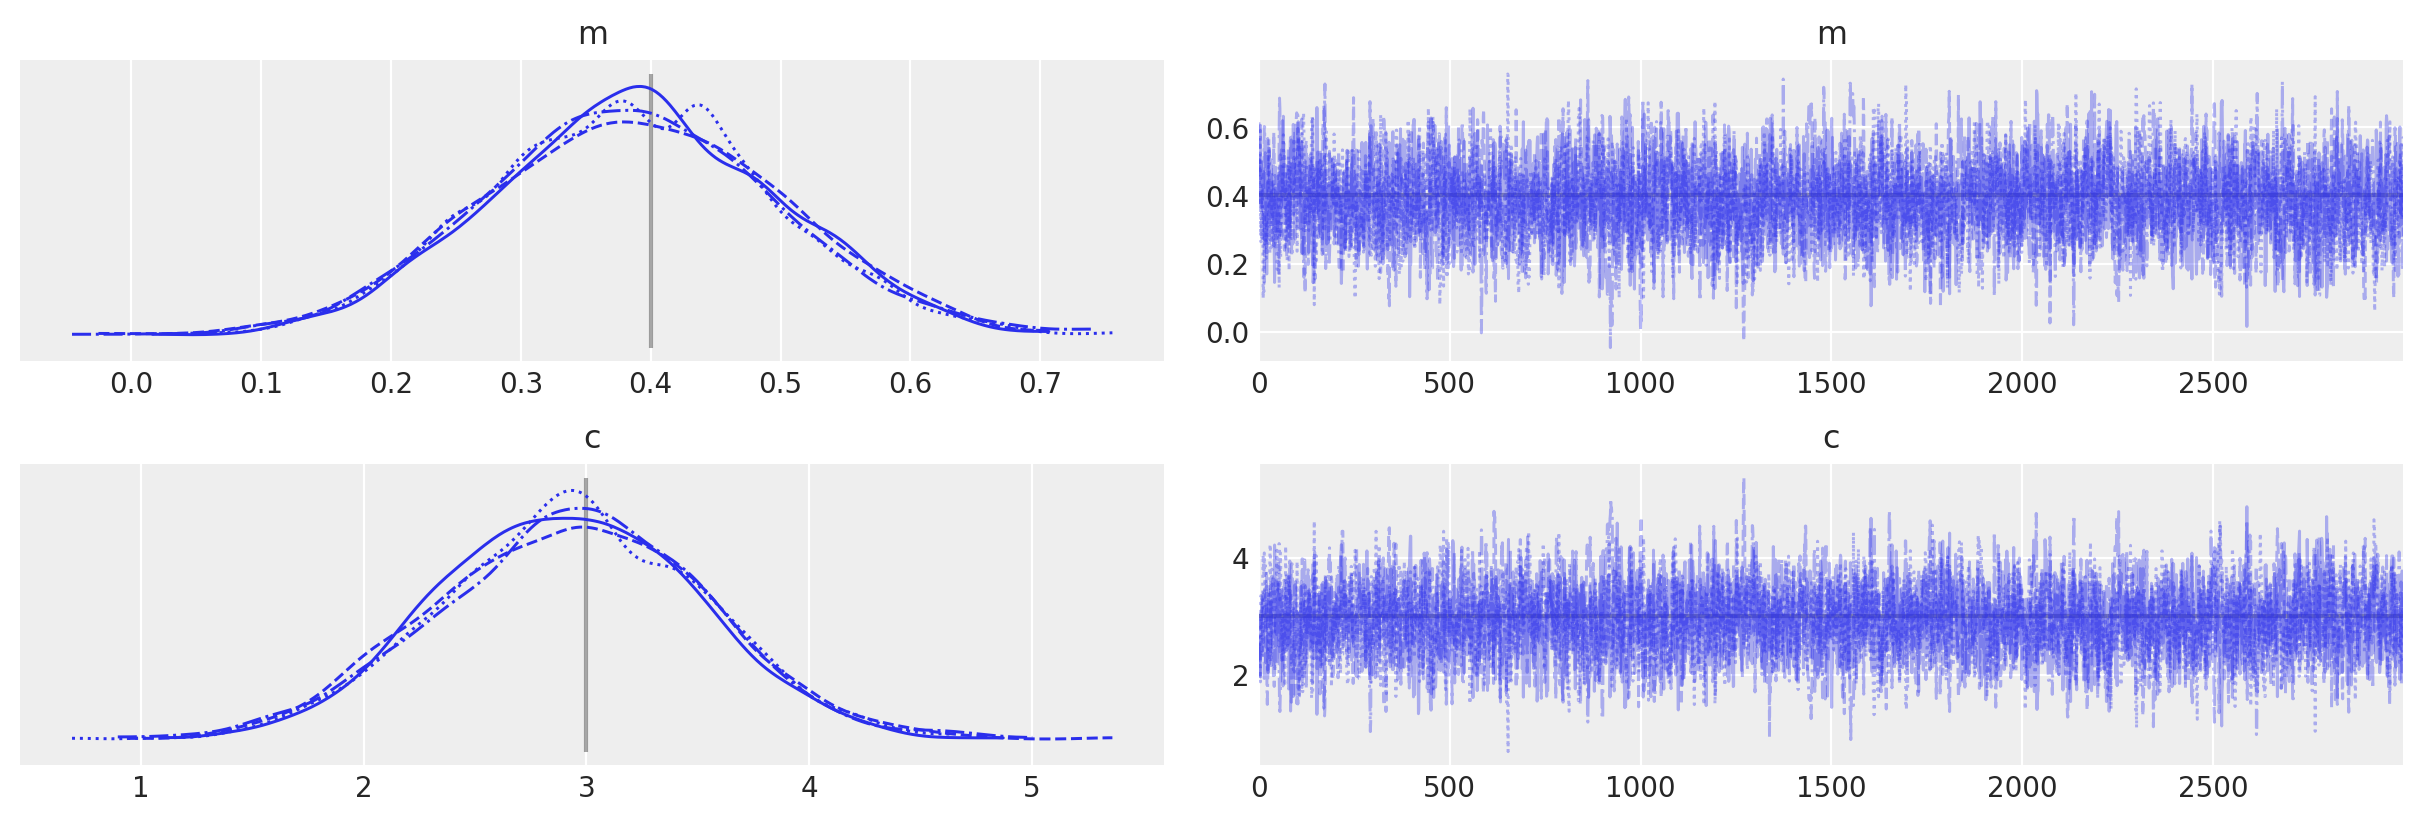

In [8]:
# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model() as opmodel:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist
    pm.DensityDist("likelihood", lambda v: logl(v), givens={"v": theta})

    idata_grad = pm.sample(ndraws, tune=nburn, return_inferencedata=True)

# plot the traces
_ = az.plot_trace(idata_grad, lines=[("m", {}, mtrue), ("c", {}, ctrue)])

# put the chains in an array (for later!)
samples_grad = idata_grad.posterior.stack(sample=("chain", "draw")).to_array().values.T

Now, finally, just to check things actually worked as we might expect, let's do the same thing purely using PyMC3 distributions (because in this simple example we can!)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, m]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8841072215120667, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


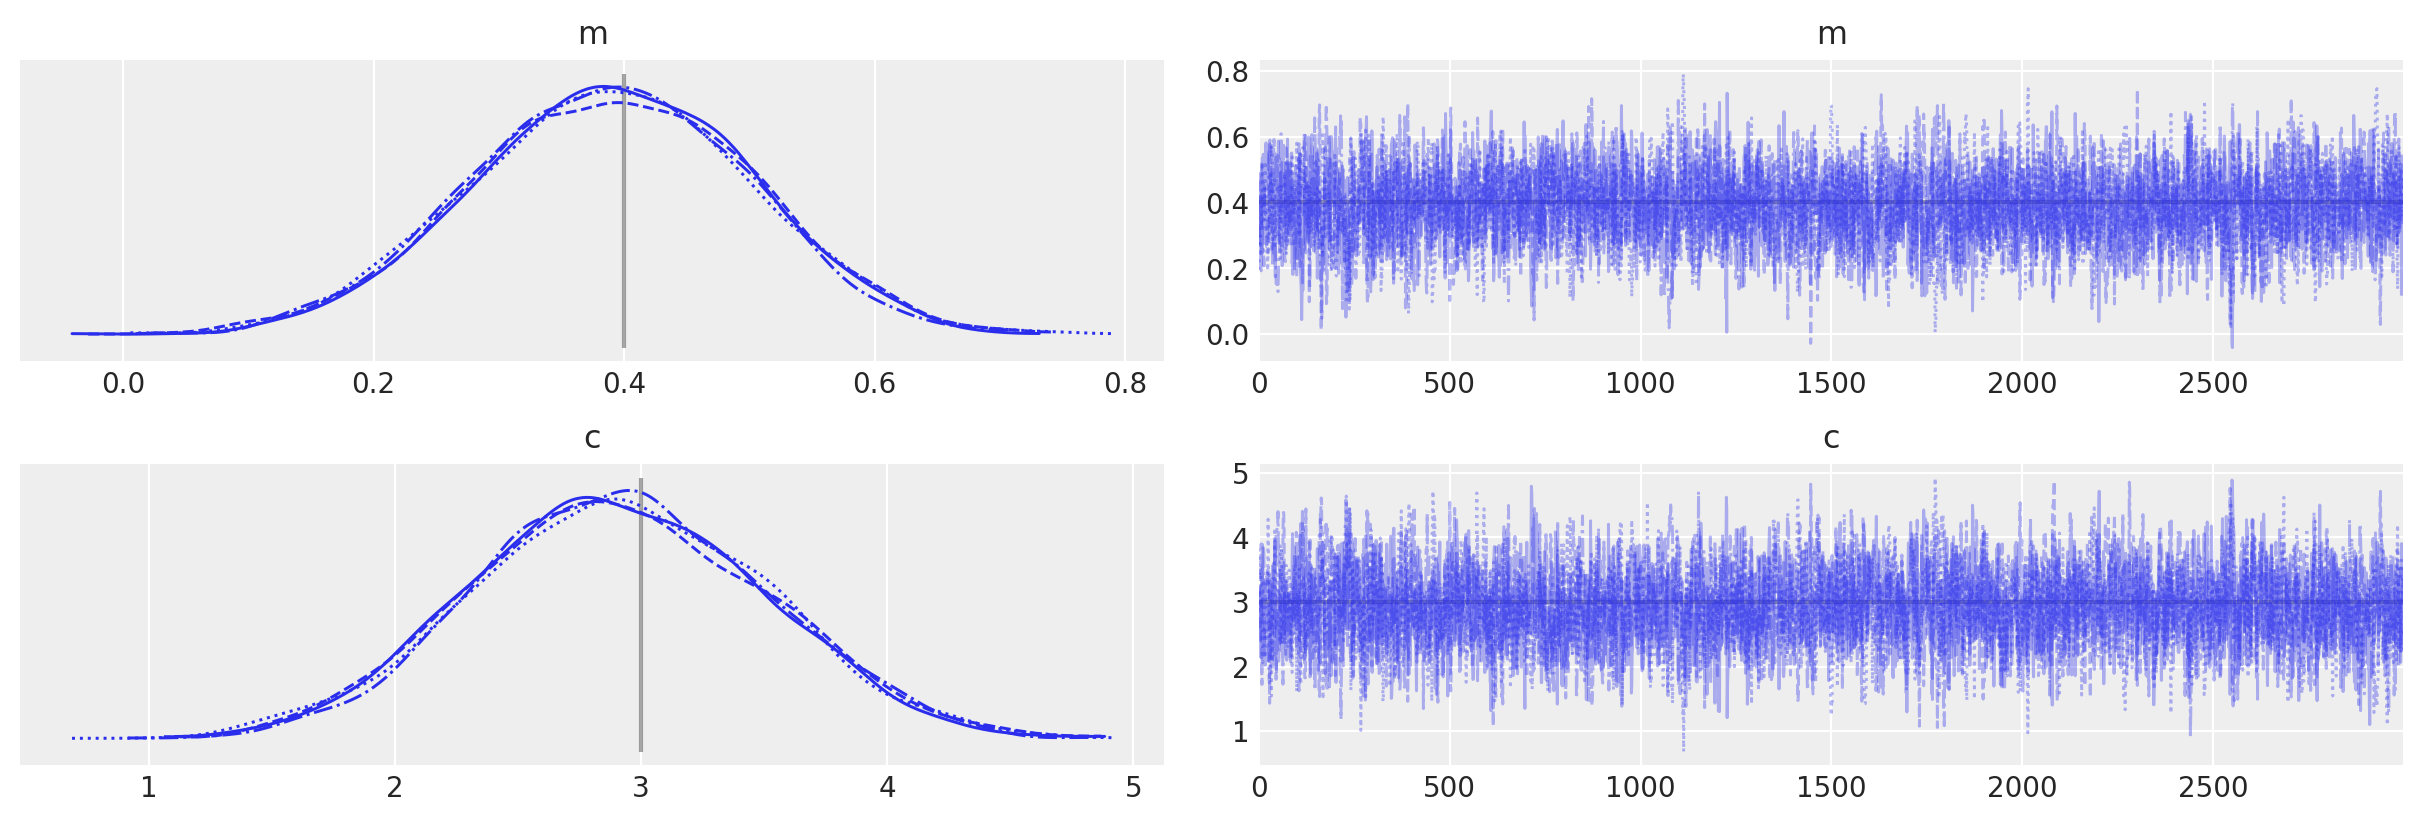

In [9]:
with pm.Model() as pymodel:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a Normal distribution
    pm.Normal("likelihood", mu=(m * x + c), sd=sigma, observed=data)

    idata = pm.sample(ndraws, tune=nburn, return_inferencedata=True)

# plot the traces
_ = az.plot_trace(idata, lines=[("m", {}, mtrue), ("c", {}, ctrue)])

# put the chains in an array (for later!)
samples_pymc3 = idata.posterior.stack(sample=("chain", "draw")).to_array().values.T

To check that they match let's plot all the examples together and also find the autocorrelation lengths.

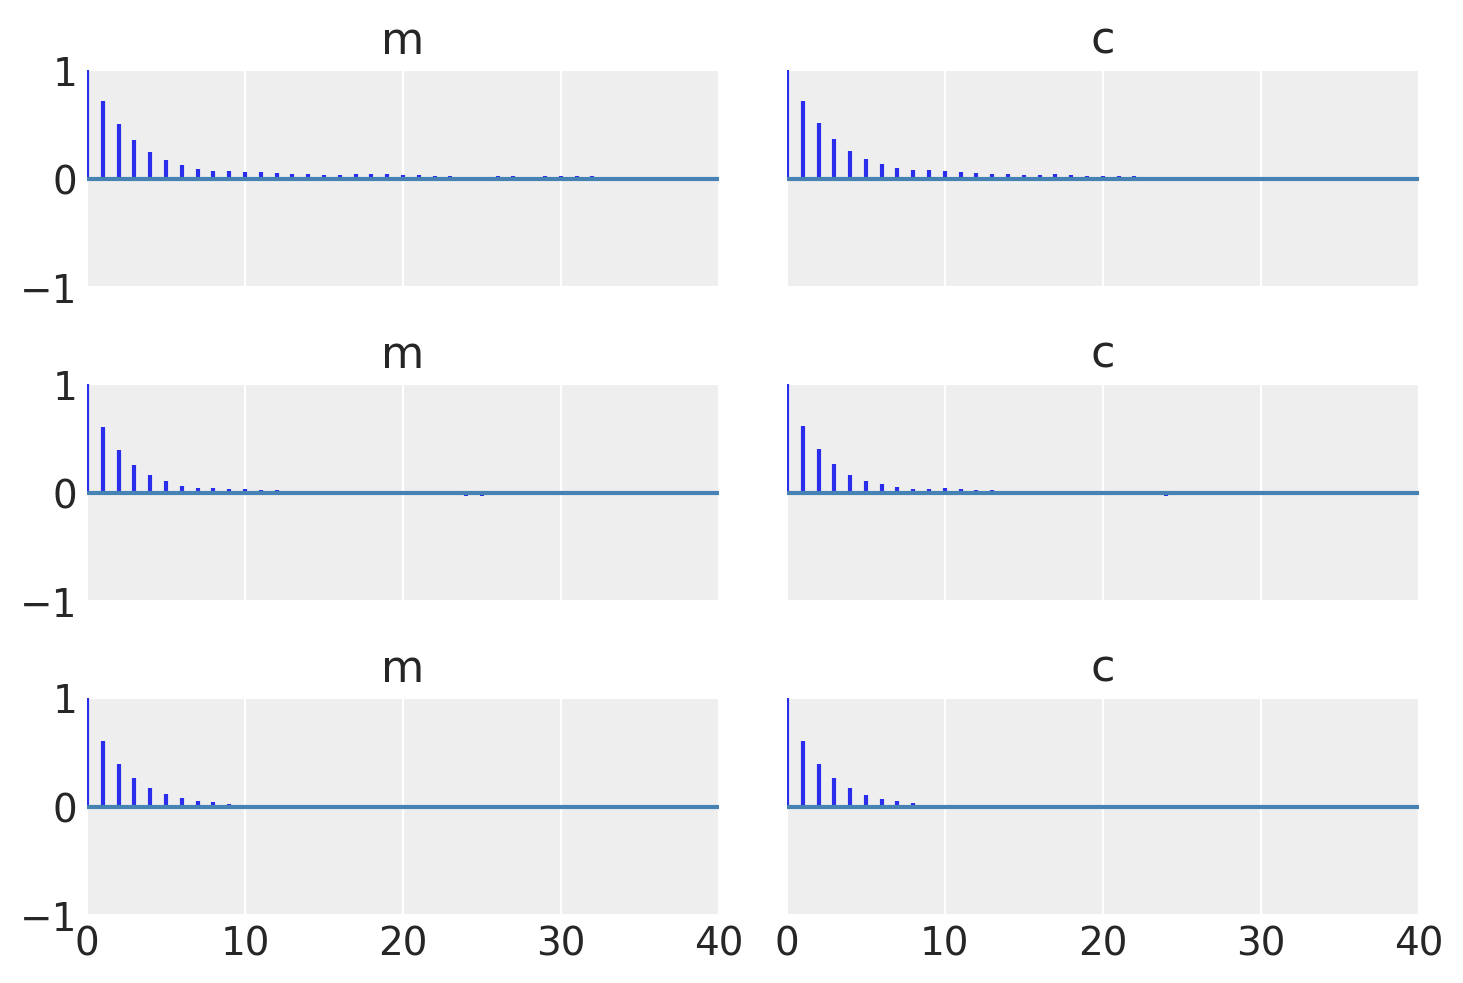

In [10]:
_, axes = plt.subplots(3, 2, sharex=True, sharey=True)
az.plot_autocorr(idata_mh, combined=True, ax=axes[0,:]);
az.plot_autocorr(idata_grad, combined=True, ax=axes[1,:]);
az.plot_autocorr(idata, combined=True, ax=axes[2,:]);
axes[2,0].set_xlim(right=40);

/home/oriol/miniconda3/envs/arviz/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


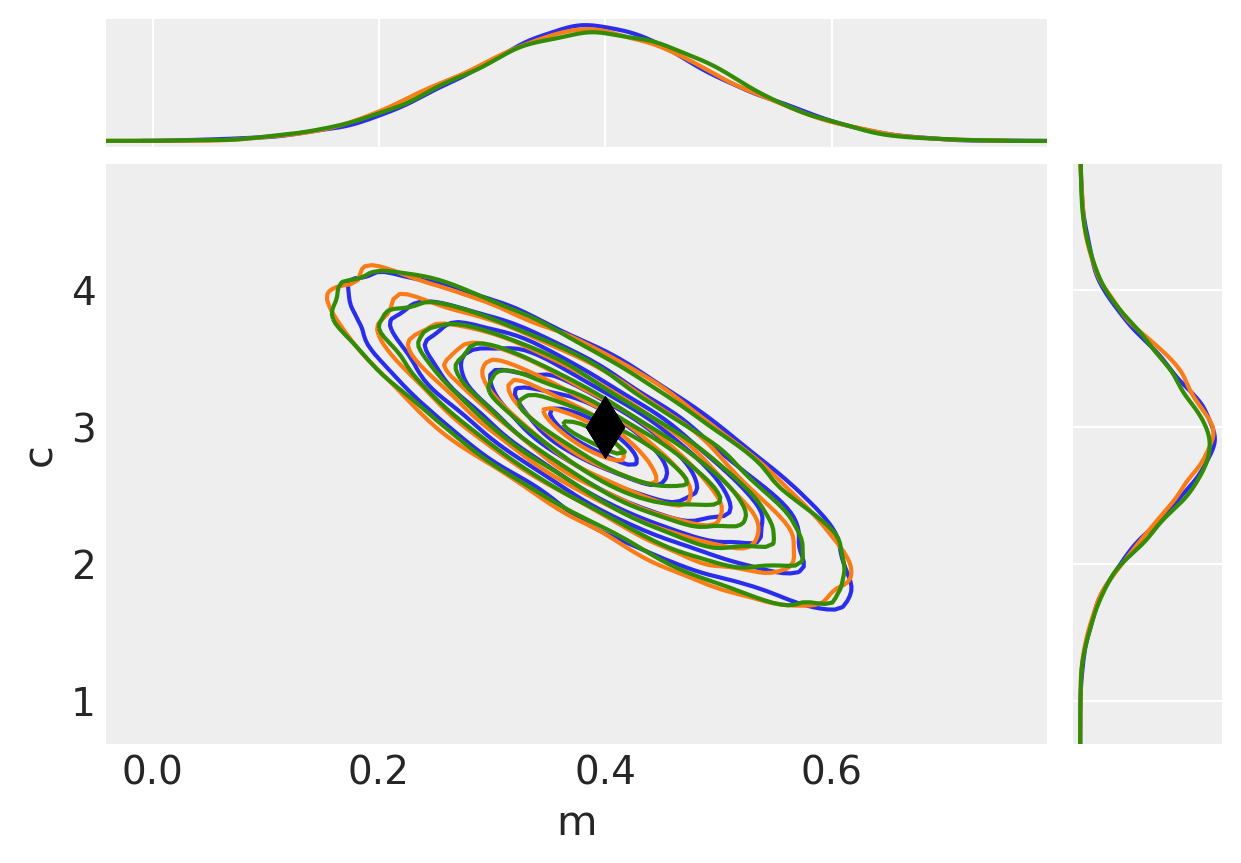

In [11]:
pair_kwargs = dict(
    kind="kde",
    marginals=True, 
    reference_values={"m": mtrue, "c": ctrue}, 
    kde_kwargs={"contourf_kwargs": {"alpha": 0}, "contour_kwargs": {"colors": "C0"}},
    reference_values_kwargs={"color": "k", "ms": 15, "marker": "d"},
    marginal_kwargs={"color": "C0"}
)
ax = az.plot_pair(idata_mh, **pair_kwargs)
pair_kwargs["kde_kwargs"]["contour_kwargs"]["colors"] = "C1"
pair_kwargs["marginal_kwargs"]["color"] = "C1"
az.plot_pair(idata_grad, **pair_kwargs, ax=ax)
pair_kwargs["kde_kwargs"]["contour_kwargs"]["colors"] = "C2"
pair_kwargs["marginal_kwargs"]["color"] = "C2"
az.plot_pair(idata, **pair_kwargs, ax=ax);

We can now check that the gradient Op works was we expect it to. First, just create and call the `LogLikeGrad` class, which should return the gradient directly (note that we have to create a [Theano function](http://deeplearning.net/software/theano/library/compile/function.html) to convert the output of the Op to an array). Secondly, we call the gradient from `LogLikeWithGrad` by using the [Theano tensor gradient](http://deeplearning.net/software/theano/library/gradient.html#theano.gradient.grad) function. Finally, we will check the gradient returned by the PyMC3 model for a Normal distribution, which should be the same as the log-likelihood function we defined. In all cases we evaluate the gradients at the true values of the model function (the straight line) that was created.

In [12]:
# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(data, x, sigma)
test_grad_op_func = theano.function([var], test_grad_op(var))
grad_vals = test_grad_op_func([mtrue, ctrue])

print(f'Gradient returned by "LogLikeGrad": {grad_vals}')

# test the gradient called through LogLikeWithGrad
test_gradded_op = LogLikeWithGrad(my_loglike, data, x, sigma)
test_gradded_op_grad = tt.grad(test_gradded_op(var), var)
test_gradded_op_grad_func = theano.function([var], test_gradded_op_grad)
grad_vals_2 = test_gradded_op_grad_func([mtrue, ctrue])

print(f'Gradient returned by "LogLikeWithGrad": {grad_vals_2}')

# test the gradient that PyMC3 uses for the Normal log likelihood
test_model = pm.Model()
with test_model:
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    pm.Normal("likelihood", mu=(m * x + c), sigma=sigma, observed=data)

    gradfunc = test_model.logp_dlogp_function([m, c], dtype=None)
    gradfunc.set_extra_values({"m_interval__": mtrue, "c_interval__": ctrue})
    grad_vals_pymc3 = gradfunc(np.array([mtrue, ctrue]))[1]  # get dlogp values

print(f'Gradient returned by PyMC3 "Normal" distribution: {grad_vals_pymc3}')

Gradient returned by "LogLikeGrad": [-7.17656625 -1.39486358]
Gradient returned by "LogLikeWithGrad": [-7.17656625 -1.39486358]
Gradient returned by PyMC3 "Normal" distribution: [-7.17656625 -1.39486358]


We can also do some [profiling](http://docs.pymc.io/notebooks/profiling.html) of the Op, as used within a PyMC3 Model, to check performance. First, we'll profile using the `LogLikeWithGrad` Op, and then doing the same thing purely using PyMC3 distributions.

In [13]:
# profile logpt using our Op
opmodel.profile(opmodel.logpt).summary()

Function profiling
  Message: /home/oriol/miniconda3/envs/arviz/lib/python3.8/site-packages/pymc3/model.py:1254
  Time in 1000 calls to Function.__call__: 4.722261e-02s
  Time in Function.fn.__call__: 0.02913379669189453s (61.695%)
  Time in thunks: 0.025211572647094727s (53.389%)
  Total compile time: 2.022645e-01s
    Number of Apply nodes: 8
    Theano Optimizer time: 6.711102e-02s
       Theano validate time: 5.106926e-04s
    Theano Linker time (includes C, CUDA code generation/compiling): 0.11913228034973145s
       Import time 0.000000e+00s
       Node make_thunk time 1.186690e-01s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2) * LE(i1, i3))), i4, i5)) - ((i6 * scalar_softplus((-i7))) + i7))}}[(0, 1)](TensorConstant{2.995732273553991}, c, TensorConstant{-10.0}, TensorConstant{10.0}, TensorConstant{-2.995732273553991}, TensorConstant{-inf}, TensorConstant{2.0}, c_interval__) time 1.156688e-01s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((G

In [14]:
# profile using our PyMC3 distribution
pymodel.profile(pymodel.logpt).summary()

Function profiling
  Message: /home/oriol/miniconda3/envs/arviz/lib/python3.8/site-packages/pymc3/model.py:1254
  Time in 1000 calls to Function.__call__: 1.784420e-02s
  Time in Function.fn.__call__: 0.005266427993774414s (29.513%)
  Time in thunks: 0.001882314682006836s (10.549%)
  Total compile time: 1.327960e-01s
    Number of Apply nodes: 11
    Theano Optimizer time: 1.072762e-01s
       Theano validate time: 8.547306e-04s
    Theano Linker time (includes C, CUDA code generation/compiling): 0.007889032363891602s
       Import time 0.000000e+00s
       Node make_thunk time 7.375240e-03s
           Node Elemwise{Composite{(i0 + (-sqr((i1 - ((i2 * i3) + i4)))))}}(TensorConstant{(1,) of -1..0664093453}, TensorConstant{[3.0596689...46571405]}, InplaceDimShuffle{x}.0, TensorConstant{[0. 1. 2. .. 7. 8. 9.]}, InplaceDimShuffle{x}.0) time 1.505852e-03s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2) * LE(i1, i3))), i4, i5)) - ((i6 * scalar_softplus((-i7))) + i7))}}

## Authors

* Readapted by [Oriol Abril](https://github.com/OriolAbril) to drop the Cython dependency from the original tutorial based on a blog post by [Matt Pitkin](http://mattpitkin.github.io/samplers-demo/pages/pymc3-blackbox-likelihood/) on August 27, 2018. At the same time, that post was based on an example provided by [Jørgen Midtbø](https://github.com/jorgenem/).

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jan 23 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

matplotlib: 3.3.3
IPython   : 7.19.0
pymc3     : 3.11.0
theano    : 1.1.0
numpy     : 1.19.4
arviz     : 0.11.0

Watermark: 2.1.0

